In [33]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import random

sns.set_theme(color_codes=True)
sys.path.insert(0, ".././0.data-download/scripts/")

from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras

import blitzgsea as blitz
import urllib.request

# Download the gene set library here: https://github.com/MaayanLab/blitzgsea


In [34]:
random.seed(18)
print(random.random())

0.18126486333322134


In [35]:
# list available gene set libraries in Enrichr
blitz.enrichr.print_libraries()

{'LIBRARY_LIST_URL': 'https://maayanlab.cloud/speedrichr/api/listlibs', 'LIBRARY_DOWNLOAD_URL': 'https://maayanlab.cloud/Enrichr/geneSetLibrary?mode=text&libraryName='}
0 - GeneSigDB
1 - Enrichr_Submissions_TF-Gene_Coocurrence
2 - SysMyo_Muscle_Gene_Sets
3 - WikiPathway_2021_Human
4 - HomoloGene
5 - WikiPathways_2013
6 - PFOCR_Pathways_2023
7 - OMIM_Disease
8 - Data_Acquisition_Method_Most_Popular_Genes
9 - Cancer_Cell_Line_Encyclopedia
10 - WikiPathways_2016
11 - WikiPathways_2015
12 - RNAseq_Automatic_GEO_Signatures_Human_Up
13 - Human_Gene_Atlas
14 - KOMP2_Mouse_Phenotypes_2022
15 - Kinase_Perturbations_from_GEO_down
16 - Disease_Signatures_from_GEO_down_2014
17 - Disease_Perturbations_from_GEO_up
18 - Old_CMAP_down
19 - MCF7_Perturbations_from_GEO_up
20 - NIH_Funded_PIs_2017_GeneRIF_ARCHS4_Predictions
21 - PPI_Hub_Proteins
22 - DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019
23 - Disease_Signatures_from_GEO_up_2014
24 - GTEx_Tissue_Expression_Up
25 - L1000_Kinase_and_GPCR_Perturbati

In [36]:
# use enrichr submodule to retrieve gene set library
# these libraries are finicky to work with--they usually work the first time but then may stop working. You may need to remove the library from your computer and trying to reimport it to work again.
library = blitz.enrichr.get_library("GO_Biological_Process_2017")

In [37]:
# load the weight matrix 
gene_weight_dir = pathlib.Path("../2.train-VAE//results/weight_matrix_gsea.csv")
signature = pd.read_csv(gene_weight_dir)
print(signature.shape)
signature.head()

(1000, 101)


0         1         2         3         4         5         6  \
0    GPX4 -0.003431 -0.066462  0.023348 -0.087693 -0.035378 -0.130166   
1   CCND1  0.041190 -0.036413 -0.073804 -0.003457  0.214047  0.094045   
2   EP300  0.042926 -0.047306 -0.007981  0.092379 -0.049409 -0.051858   
3    CDK6  0.025111 -0.041455 -0.056006  0.023690 -0.043088 -0.094552   
4  TXNRD1  0.000167 -0.018388 -0.069532 -0.096174 -0.059824 -0.032566   

          7         8         9  ...        91        92        93        94  \
0 -0.011303  0.002215  0.065100  ... -0.122327 -0.089983  0.008672 -0.032056   
1 -0.096939 -0.046628  0.055162  ...  0.073669  0.104024  0.006950  0.009301   
2 -0.000272 -0.015936 -0.088256  ... -0.071827 -0.009377  0.067449 -0.054565   
3  0.011754 -0.006810 -0.007835  ... -0.105212 -0.081106  0.022533 -0.052183   
4  0.070643  0.013985 -0.008484  ...  0.083347  0.030248  0.009382  0.011457   

         95        96        97        98        99       100  
0 -0.070818 -0.042180 -0.043921  0.070101 -0.021080 -0.009599  
1  0.074342 -0.054289  0.122823 -0.103081 -0.096315  0.040273  
2  0.000477 -0.000918 -0.092843  0.085447 -0.072340  0.031898  
3 -0.101708 -0.038274 -0.148809 -0.038718 -0.024035  0.003900  
4 -0.023764 -0.003427 -0.043586 -0.049834 -0.042049  0.007481  

[5 rows x 101 columns]

In [38]:
all_GSEA_results = []
all_signatures = []
neg_GSEA_results = []
negative_control = []

for col in signature.iloc[:,1:101].columns:
    df = signature.iloc[:,[0,int(col)]]
    result = blitz.gsea(df, library)
    all_GSEA_results.append(result.assign(z_dim=f"z_{col}"))
    all_signatures.append(df)
    neg_df = df.copy()
    neg_df[col] = neg_df[col].sample(frac=1).reset_index(drop=True)
    neg_result = blitz.gsea(neg_df, library)
    neg_GSEA_results.append(neg_result.assign(z_dim=f"z_{col}"))
    negative_control.append(neg_df)

all_GSEA_results
neg_GSEA_results

[                                                          es       nes  \
 Term                                                                     
 nuclear-transcribed mRNA catabolic process, non...  0.718474 -2.764519   
 RNA splicing (GO:0008380)                           0.695708 -2.636008   
 cell division (GO:0051301)                         -0.866429  2.572334   
 membrane organization (GO:0061024)                 -0.505356  2.321942   
 cell-matrix adhesion (GO:0007160)                   0.699315 -2.292003   
 ...                                                      ...       ...   
 endoplasmic reticulum organization (GO:0007029)    -0.255204  0.013246   
 cell growth (GO:0016049)                           -0.219780  0.002686   
 viral life cycle (GO:0019058)                      -0.217933  0.000852   
 release of cytochrome c from mitochondria (GO:0... -0.209712  0.000000   
 T cell receptor signaling pathway (GO:0050852)     -0.214286  0.000000   
 
                       

In [39]:
# stack up all of the results to be analyzed
all_GSEA_results= pd.concat(all_GSEA_results)
neg_GSEA_results = pd.concat(neg_GSEA_results)

In [40]:
# sort by what you want to evaluate
all_GSEA_results['rank'] = (-np.log10(all_GSEA_results.pval))*(all_GSEA_results.es)
all_GSEA_results.sort_values(by='pval', ascending = True)

# neg_GSEA_results['rank'] = (-np.log10(neg_GSEA_results.pval))*(neg_GSEA_results.es)
# neg_GSEA_results.sort_values(by='es', ascending = False)

es       nes  \
Term                                                                     
mitochondrial translational elongation (GO:0070...  0.523766      -inf   
mitochondrial translational termination (GO:007...  0.515150 -8.014016   
mitochondrial translational elongation (GO:0070...  0.484045 -7.653620   
mitochondrial translational termination (GO:007...  0.491193 -7.375567   
mitochondrial translational elongation (GO:0070...  0.515382 -5.723523   
...                                                      ...       ...   
transcription elongation from RNA polymerase II...  0.219318  0.000000   
Fc-epsilon receptor signaling pathway (GO:0038095)  0.200285  0.000000   
protein ubiquitination (GO:0016567)                 0.158608  0.000000   
transcription initiation from RNA polymerase II... -0.202909  0.000000   
positive regulation of cysteine-type endopeptid...  0.224121  0.000000   

                                                            pval  \
Term                                                               
mitochondrial translational elongation (GO:0070...  1.114201e-17   
mitochondrial translational termination (GO:007...  1.214502e-15   
mitochondrial translational elongation (GO:0070...  1.955760e-14   
mitochondrial translational termination (GO:007...  1.636370e-13   
mitochondrial translational elongation (GO:0070...  1.043373e-08   
...                                                          ...   
transcription elongation from RNA polymerase II...  1.000000e+00   
Fc-epsilon receptor signaling pathway (GO:0038095)  1.000000e+00   
protein ubiquitination (GO:0016567)                 1.000000e+00   
transcription initiation from RNA polymerase II...  1.000000e+00   
positive regulation of cysteine-type endopeptid...  1.000000e+00   

                                                           sidak  \
Term                                                               
mitochondrial translational elongation (GO:0070...  2.651798e-15   
mitochondrial translational termination (GO:007...  2.890516e-13   
mitochondrial translational elongation (GO:0070...  4.654709e-12   
mitochondrial translational termination (GO:007...  3.894561e-11   
mitochondrial translational elongation (GO:0070...  2.483224e-06   
...                                                          ...   
transcription elongation from RNA polymerase II...  1.000000e+00   
Fc-epsilon receptor signaling pathway (GO:0038095)  1.000000e+00   
protein ubiquitination (GO:0016567)                 1.000000e+00   
transcription initiation from RNA polymerase II...  1.000000e+00   
positive regulation of cysteine-type endopeptid...  1.000000e+00   

                                                             fdr  \
Term                                                               
mitochondrial translational elongation (GO:0070...  2.651798e-15   
mitochondrial translational termination (GO:007...  1.445258e-13   
mitochondrial translational elongation (GO:0070...  4.654709e-12   
mitochondrial translational termination (GO:007...  1.947281e-11   
mitochondrial translational elongation (GO:0070...  2.483227e-06   
...                                                          ...   
transcription elongation from RNA polymerase II...  1.000000e+00   
Fc-epsilon receptor signaling pathway (GO:0038095)  1.000000e+00   
protein ubiquitination (GO:0016567)                 1.000000e+00   
transcription initiation from RNA polymerase II...  1.000000e+00   
positive regulation of cysteine-type endopeptid...  1.000000e+00   

                                                    geneset_size  \
Term                                                               
mitochondrial translational elongation (GO:0070...            63   
mitochondrial translational termination (GO:007...            62   
mitochondrial translational elongation (GO:0070...            63   
mitochondrial translational termination (GO:007...            62   
mitochondrial translational elon

Text(0.5, 1.0, 'Control Gene Set Enrichment Analysis')

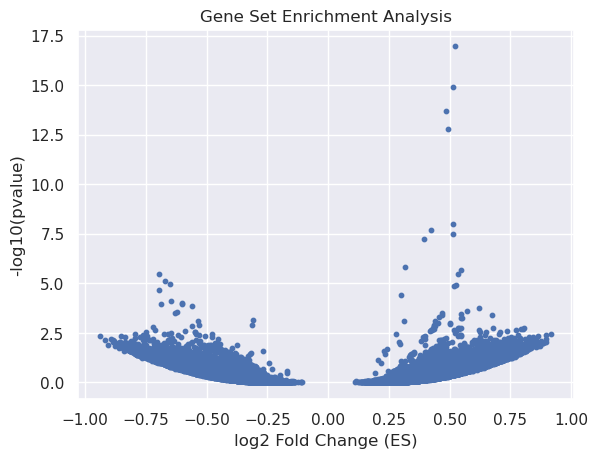

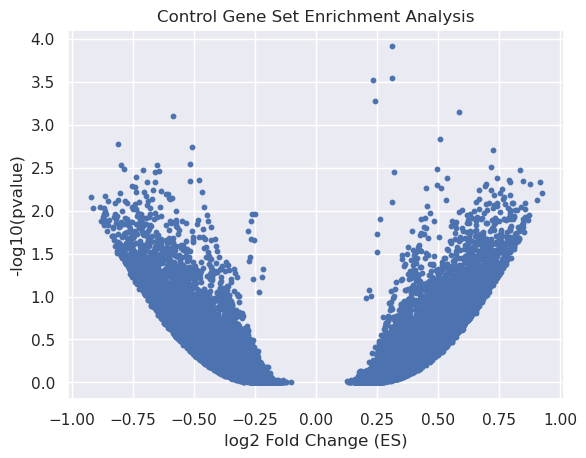

In [41]:
plt.figure()
plt.scatter(x=all_GSEA_results['es'],y=all_GSEA_results['pval'].apply(lambda x:-np.log10(x)),s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Gene Set Enrichment Analysis')

plt.figure()
plt.scatter(x=neg_GSEA_results['es'],y=neg_GSEA_results['pval'].apply(lambda x:-np.log10(x)), s=10)
plt.xlabel('log2 Fold Change (ES)')
plt.ylabel('-log10(pvalue)')
plt.title('Control Gene Set Enrichment Analysis')

In [ ]:
# Using VAE generated data

z = 0
for df in all_signatures:
    
    z = z+1

    fig = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=result, compact=False)
    fig.savefig("running_sum_z_" + str(z) + ".png", bbox_inches='tight')

    fig_compact = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=result, compact=True)
    fig_compact.savefig("running_sum_compact_z_" + str(z) + ".png", bbox_inches='tight')

    fig_table = blitz.plot.top_table(df, library, result, n=15)
    fig_table.savefig("top_table_z_" + str(z) + ".png", bbox_inches='tight')

# Using negative control

z = 0
for df in negative_control:
    
    z = z+1

    fig = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=result, compact=False)
    fig.savefig("running_sum_neg_z_" + str(z) + ".png", bbox_inches='tight')

    fig_compact = blitz.plot.running_sum(df, "regulation of transcription from RNA polymerase II promoter in response to hypoxia (GO:0061418)", library, result=result, compact=True)
    fig_compact.savefig("running_sum_compact_neg_z_" + str(z) + ".png", bbox_inches='tight')

    fig_table = blitz.plot.top_table(df, library, result, n=15)
    fig_table.savefig("top_table_neg_z_" + str(z) + ".png", bbox_inches='tigh t')


{'SEM1', 'PSMB7', 'UBC', 'PSMC2', 'PSME1', 'PSME2', 'UBE2D3', 'HIGD1A', 'PSMD2', 'PSMA7', 'PSME4', 'PSMB1', 'PSMB11', 'UBE2D1', 'PSMB10', 'PSMD8', 'HIF3A', 'PSMB6', 'PSMD13', 'STOX1', 'HIF1A', 'PSMC4', 'EGLN3', 'PSMD4', 'PSMB3', 'PSMA3', 'PSMA8', 'VHL', 'EGLN2', 'PSMA6', 'PSMC5', 'ARNT', 'EP300', 'UBA52', 'ELOC', 'PSMB8', 'PSMA5', 'BACH1', 'CA9', 'PSMA4', 'PSMD6', 'CUL2', 'PSMC6', 'PSMD14', 'LIMD1', 'PSMB9', 'PSMA2', 'UBB', 'PSMD11', 'PSMD10', 'PSMF1', 'PSMC3', 'CREBBP', 'RBX1', 'EPO', 'EPAS1', 'PSMC1', 'UBE2D2', 'PSMD1', 'PSMB2', 'PSMB5', 'PSMB4', 'PSMD7', 'RPS27A', 'PSME3', 'VEGFA', 'ELOB', 'PSMD9', 'PSMD12', 'EGLN1', 'HIF1AN', 'PSMA1', 'PSMD3', 'PSMD5'}
[-1.00502513e-03 -2.01005025e-03 -3.01507538e-03 -4.02010050e-03
 -5.02512563e-03 -6.03015075e-03 -7.03517588e-03 -8.04020101e-03
 -9.04522613e-03 -1.00502513e-02 -1.10552764e-02 -1.20603015e-02
 -1.30653266e-02 -1.40703518e-02 -1.50753769e-02 -1.60804020e-02
 -1.70854271e-02 -1.80904523e-02 -1.90954774e-02 -2.01005025e-02
 -2.110552